## Example with HCV data

In [1]:
# Formatting and plotting packages
%load_ext nb_black
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%config InlineBackend.figure_formats = ['svg']

from Bio import AlignIO
import numpy as np

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu" # gpu is slower

import jax.numpy as jnp
import jax
from jax.scipy.special import xlogy

jax.config.update("jax_enable_x64", True)

from vbsky.fasta import SeqData
from vbsky.bdsky import _lognorm_logpdf
from vbsky.prob import VF
from vbsky.prob.transform import (
    Transform,
    Compose,
    Positive,
    ZeroOne,
    DiagonalAffine,
    Exp,
)
from vbsky.prob.distribution import Constant
from vbsky.plot import plot_helper, plot_one

<IPython.core.display.Javascript object>

#### Import Data

In [2]:
filePath = "ncbi_allFluAH3N2_2024-05-07_Thailand_final.fasta"
hcv = AlignIO.read(filePath, format="fasta")
data = SeqData(hcv, gisaid=True, contemp=False, dates=None)

<IPython.core.display.Javascript object>

#### Data Preprocessing

In this step we are 
1. Sampling with replacement to create subsamples 
2. Estimating the tree topologies for each subsample
3. Preprocessing data to be used in the optimizer

In [3]:
n_tips = 100  # Number of tips per tree, 100 used in paper
n_trees = 6  # Number of trees
# "number of trees in the ensemble was set to be the smallest integer such that the number of trees multiplied by 100 was larger than the 
# number of sampled sequences."
temp_folder = "./"  # Place to save temporary folders
tree_path = "./subsample.trees"

data.prep_data(
    n_tips,
    n_trees,
    temp_folder,
    tree_path,
)

Readying trees


100%|███████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.35it/s]


Writing phylo trees
Processing trees


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1870.93it/s]

Readying tip data



100%|███████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 45.75it/s]


<IPython.core.display.Javascript object>

#### Define Parameters of the Model

We define parameters through "flows" which are simply a series of transformations. Recall that we use a mean field approximation, so the posteriors are normal distributions. By transforming the normal distributions with the flows we can ensure that various parameters are constrained to the correct set of values.

Below we define two flows that we will use many times: 'pos' ensures the parameter is positive and 'z1' ensures the parameter is in (0,1). There are many more transformations available and longer sequences of transformations can also be chained for more flexible posterior distributions. If we want to fix parameters we can simply set them to be constant.

In [4]:
pos = Compose(DiagonalAffine, Exp)
z1 = Compose(DiagonalAffine, ZeroOne)

<IPython.core.display.Javascript object>

In [5]:
m = 100  # Set the number of intervals (length of vector of BDSKY parameters), same as BEAST for now

# Define local parameters for the different trees in our ensemble using z1 flow to ensure branch parameters
# are constrained appropriately
local_flows = [
    {"proportions": Transform(td.n - 2, z1), "root_proportion": Transform(1, z1)}
    for td in data.tds
]

<IPython.core.display.Javascript object>

Since we only have samples from a single time point we can set the sampling rate $s$ and origin_start to be fixed values. We also fix the clock rate. For the other variables we use either the zero-one or exponential transformation to constrain appropriately.

In [6]:
# Define global epidemiological parameters
global_flows = VF(
    origin=Transform(1, pos),
    origin_start=Constant(data.earliest), # was 0.0, looks way better like this!
    delta=Transform(m, pos),
    R=Transform(m, pos),
    rho_m=Transform(1, z1),
    s=Constant(np.repeat(0.02, m)), # was 0.00
    precision_R=Transform(1, pos),
    precision_delta=Transform(1, pos),
    clock_rate=Constant(4.4e-3), # for flu
)

data.setup_flows(global_flows, local_flows) 

<IPython.core.display.Javascript object>

#### Define Priors

To match the flexibility of the flows, users must provide the prior distributions. We need to provide priors for all  parameters defined to be non-constant. Additionally, we can add a GMRF smoothing parameter to enforce smoother estimates of the BDSKY parameters. 

In [7]:
# Define a function to give value of prior given parameters
def _params_prior_loglik(params):
    ll = 0
    # Hyperprior for gmrf smoothing prior
    tau = {"R": params["precision_R"][0], "delta": params["precision_delta"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.gamma.logpdf(tau["delta"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.beta.logpdf(params["rho_m"], 1, 9999).sum()

    mus = [1.0, 1.0, 1.0]
    sigmas = [1.25, 1.25, 1.25]

    for i, k in enumerate(["R", "delta", "origin"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    # gmrf smoothing
    for k in ["R", "delta"]:
        log_rate = jnp.log(params[k])
        ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
        m = len(log_rate)
        ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))

    return ll

<IPython.core.display.Javascript object>

#### Run Optimization Loop and Visualize Posteriors

After we have defined our parameters we can run the optimization step and sample from the posterior distributions.

0

100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.66it/s]


1

 97%|██████████████████████████████████████████████████████████████████████████████████▏  | 58/60 [00:10<00:00,  5.74it/s]


2

100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.62it/s]


3

 98%|███████████████████████████████████████████████████████████████████████████████████▌ | 59/60 [00:10<00:00,  5.65it/s]


4

100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.54it/s]


5

 95%|████████████████████████████████████████████████████████████████████████████████▊    | 57/60 [00:10<00:00,  5.48it/s]


6

 97%|██████████████████████████████████████████████████████████████████████████████████▏  | 58/60 [00:10<00:00,  5.48it/s]


7

100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.00it/s]


8

 95%|████████████████████████████████████████████████████████████████████████████████▊    | 57/60 [00:12<00:00,  4.71it/s]


9

100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.82it/s]


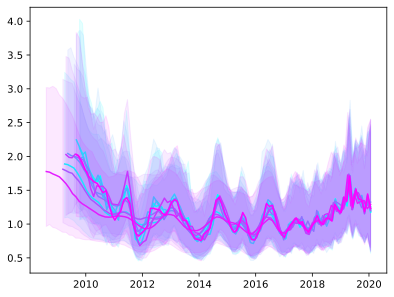

<IPython.core.display.Javascript object>

In [12]:
num_plots = 10
fig, ax = plt.subplots()
colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))
for i in range(0,num_plots):
    display(i)
    rng = jax.random.PRNGKey(6)
    n_iter = 10
    threshold = 0.001
    step_size = 1.0
    
    res = data.loop(
        _params_prior_loglik,
        rng,
        n_iter,
        step_size=step_size,
        threshold=threshold,
    )
    color_i = colors[i]
    start, top, end, x0 = plot_helper(res, data, n_tips)
    plot_one(res, ax, "R", m, start, top, end, x0, "R", "fill", "", color_i) # R = effective reproduction number